In [2]:
# !pip install -q tensorflow-datasets
# !pip install -U efficientnet

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
# load dataset
imagenette_dataset = tfds.load(
    'imagenette/320px-v2',
    split='validation',
    data_dir="dataset/",
    # shuffle_files=True,
    as_supervised=True,
)

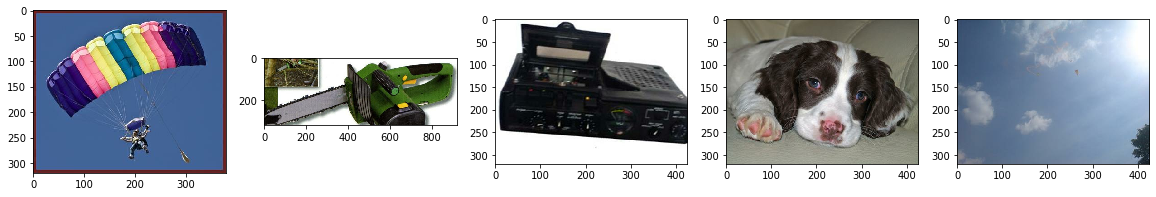

In [4]:
# show examples
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

for idx, example in enumerate(imagenette_dataset.take(5)):
    # print(example[0], example[1])
    image, label = example
    arr_ = np.squeeze(image)
    axes[idx].imshow(image)
plt.show()

In [5]:
# utils

# data normalization
def resize_img_224(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label

def resize_img_299(image, label):
    image = tf.image.resize(image, (299, 299))
    return image, label

def normalized_img(image, label):
    image = tf.cast(image, tf.float32) / 255.
    return image, label

# model generator
def model_generator(names_list, dataset):
    model_result = None
    model = None
    ds_test = None
    params_count = None
    for name in names_list:
        if name == "mobilenet":
            model = tf.keras.applications.mobilenet.MobileNet(weights='imagenet')
            # dataset generator
            ds_test = dataset.map(resize_img_224)
            ds_test = ds_test.map(normalized_img)
        elif name == "vgg16":
            model = tf.keras.applications.vgg16.VGG16(weights='imagenet')
            ds_test = dataset.map(resize_img_224)
        elif name == "inception_v3":
            model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet')
            ds_test = dataset.map(resize_img_299)
            ds_test = ds_test.map(normalized_img)
        elif name == "resnet50":
            model = tf.keras.applications.resnet50.ResNet50(weights='imagenet')
            ds_test = dataset.map(resize_img_224)
        elif name == "efficientnet":
            pass

        if model:
            ds_test = ds_test.cache()
            ds_test = ds_test.batch(128)

            model.compile(
                loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'],
            )
            predictions = model.predict(ds_test, verbose=1)
            model_result = tf.keras.applications.imagenet_utils.decode_predictions(predictions, top=5)
            params_count = model.count_params()
        yield model_result, params_count

#

In [6]:
# dataset description
classes = {
    0:'English springer',
    1: "French horn",
    2: "cassette player",
    3: "chain saw",
    4: "church",
    5: "garbage truck",
    6: "gas pump",
    7: "golf ball",
    8: "parachute",
    9: "tench"
}

labels_dict = {
   0: "n01440764",
   1: "n02102040",
   2: "n02979186",
   3: "n03000684",
   4: "n03028079",
   5: "n03394916",
   6: "n03417042",
   7: "n03425413",
   8: "n03445777",
   9: "n03888257"
}

In [7]:
# calculation
def top_k_accuracy(y_preds, y_real):
    is_right_ans = False
    for pred in y_preds:
        if y_real == pred:
            is_right_ans = True
            break
    return is_right_ans

# model_names_list = ["inception_v3"]
model_names_list = ["mobilenet", "vgg16", "inception_v3", "resnet50"]
gen_iter = model_generator(model_names_list, imagenette_dataset)

models_results = []
model_top5_results = {}
for name in model_names_list:
    # iterator for dataset (labels)
    ds_iterator = imagenette_dataset.as_numpy_iterator()

    model_result, params_count = next(gen_iter)
    # TODO top_5 algorithm
    get_codes = lambda item: [i[0] for i in item]
    y_preds = [get_codes(item) for item in model_result]


    # print(y_preds[0], ds_iterator)
    top = [0, 0]
    for y_5_preds in y_preds:
        y_real = labels_dict[ds_iterator.next()[1]]
        is_right_ans = top_k_accuracy(y_5_preds, y_real)
        if is_right_ans:
            top[0] += 1
        else:
            top[1] += 1

    model_top5_results["name"] = name
    model_top5_results["acc"] = top[0]/(top[0]+top[1])*100
    model_top5_results["params_count"] = params_count
    models_results.append(model_top5_results.copy())

     31/Unknown - 19s 601ms/step

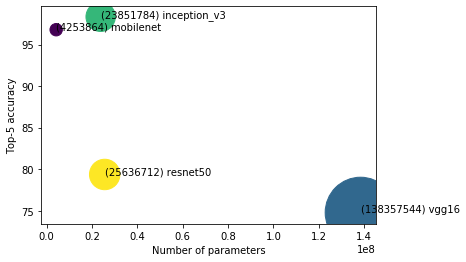

In [8]:
# visualization
name = []
x = []
y = []
z = []
color = []
data = model_top5_results
for idx, model_result in enumerate(models_results):
    name.append(model_result["name"])
    x.append(model_result["params_count"])
    y.append(model_result["acc"])
    z.append(model_result["params_count"])
    color.append(idx)

#create scatter plot
name = np.asarray(name)
x = np.asarray(x)
y = np.asarray(y)
z = np.asarray(z)
size = 5000
norm_z = z/z.max()*size

fig, ax = plt.subplots()
ax.scatter(z,y,s=norm_z,marker='o', c=color)

#label each bubble
for i in range(len(z)):
    plt.annotate("(%s) %s" % (x[i], name[i]),xy=(z[i], y[i]))

#Label axis
plt.xlabel('Number of parameters')
plt.ylabel('Top-5 accuracy')
plt.show()

# https://colab.research.google.com/github/idealo/imageatm/blob/master/examples/imageatm_imagenette.ipynb#scrollTo=XXMGAekAuY7L